In [1]:
# Parameters
cpu = 8
group_name = "Astro-TE_NN"
mem_gb = 10


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from glob import glob
import time
import cooler
import subprocess
import glob
import pathlib
from tqdm import tqdm
from collections import defaultdict

In [3]:
#group_name = 'DG_Glut'

In [4]:
home_dir = '/home/qzeng_salk_edu/project/241018_pre_ml/'
ct = group_name


In [5]:
gene_meta = pd.read_csv('/data/ref/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t')
use_gene_types = ['protein_coding','lncRNA']

use_genes = pd.read_csv(f'{home_dir}/mm10_gene_2kb.bed', index_col = None, header = None, sep = '\t')
use_genes = use_genes[5].values

In [6]:
import pathlib
# make a dir ml_input/{ct}
pathlib.Path(f'{home_dir}/ml_input/{ct}').mkdir(parents=True, exist_ok=True)

In [7]:
# my deg analysis
pvalue_cut = 1e-5
log2fc_cut = 0.3


expr = pd.read_hdf(f'/data/female-amb/Diff.Result/DEG.stats/{ct}/expr.hdf').T
expr = expr + 1e-5
all_genes = pd.read_hdf(f'/data/female-amb/Diff.Result/DEG.stats/{ct}/deg_stats.hdf')
all_genes['log2(old/young)'] = np.log2(expr[f"{ct}.18mo"]/expr[f"{ct}.2mo"])

# highly expressed genes
highly_expressed_genes = expr.sum(axis = 1)[expr.sum(axis = 1) > 1e-3].index
all_genes = all_genes.loc[all_genes.index.isin(highly_expressed_genes)]

# add a column in all_genes, if the gene not in deg_df the value = 0; if the value in deg_df['avg_log2FC'] > 0, the value = -1; if the value in deg_df['avg_log2FC'] < 0, the value = 1
deg_df = all_genes[(all_genes['fdr'] < pvalue_cut) & (np.abs(all_genes['log2(old/young)']) > log2fc_cut)]
all_genes['DEG'] = 0
all_genes.loc[deg_df.index, 'DEG'] = all_genes.loc[deg_df.index, 'log2(old/young)'].apply(lambda x: 1 if x > 0 else -1)
all_genes = all_genes[all_genes.index.isin(use_genes)]

min_value = all_genes[all_genes['fdr'] != 0].sort_values('fdr').iloc[0]['fdr']
all_genes['-log10(fdr)'] = -np.log10(all_genes['fdr'] + min_value)
all_genes

,stats,fdr,log2(old/young),DEG,-log10(fdr)
gene,,,,,
Xkr4,23.941545,0.000044,0.500929,0,4.354202
Mrpl15,3.136794,0.290830,-0.269553,0,0.536361
Lypla1,23.228939,0.000060,0.207979,0,4.222170
Tcea1,23.091860,0.000064,-0.363972,0,4.197146
Rgs20,0.094349,0.964279,0.009778,0,0.015797
...,...,...,...,...,...
Ugt1a7c,4.431107,0.171815,2.399207,0,0.764940
Fxyd3,1.814598,0.493208,1.681933,0,0.306970
Acsm5,28.559128,0.000007,0.120010,0,5.177882


In [8]:
all_genes = all_genes[all_genes.index.isin(use_genes)]
all_genes['DEG'].value_counts()

DEG
 0    13098
 1      259
-1      235
Name: count, dtype: int64

In [9]:
all_genes.to_csv(f"{home_dir}/ml_input/{ct}/{ct}.RNA_DEG.csv")

## luida deg

In [10]:
pvalue_cut = 1e-2
log2fc_cut = 0.3

#luisa deg analysis
deg_dir = '/data/female-amb/Diff.Result/luisa_deg'
# load luisa results
df= pd.read_csv(f'{deg_dir}/{ct}.csv', index_col=0)
#select the DEGs bt the cutoffs
deg_df = df[(df['p_val_adj'] < pvalue_cut) & (np.abs(df['avg_log2FC']) > log2fc_cut)]
deg_df.head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
Apoe,4.010310e-146,1.018486,0.849,0.636,1.041638e-141
Clu,1.275650e-123,1.344176,0.621,0.366,3.313372e-119
Cst3,1.423438e-120,1.101727,0.830,0.663,3.697239e-116
Dach1,6.551953e-77,-1.430716,0.214,0.396,1.701804e-72
Sema6d,8.820603e-66,0.835293,0.638,0.453,2.291063e-61


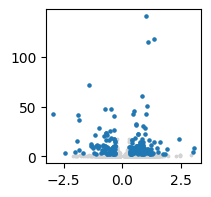

In [11]:
# plot the volcano plot, with df in the background  and DEGs in the foreground
fig, ax = plt.subplots(figsize=(2,2))
ax.scatter(df['avg_log2FC'], -np.log10(df['p_val_adj']), s=3, color='lightgray')
ax.scatter(deg_df['avg_log2FC'], -np.log10(deg_df['p_val_adj']), s=5)

In [12]:
df['DEG'] = 0
df.loc[deg_df.index, 'DEG'] = df.loc[deg_df.index, 'avg_log2FC'].apply(lambda x: -1 if x > 0 else 1)

In [13]:
df = df.loc[df.index.isin(use_genes)]

In [14]:
df.sort_values('p_val_adj').head(20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,DEG
Apoe,4.010310e-146,1.018486,0.849,0.636,1.041638e-141,-1
Clu,1.275650e-123,1.344176,0.621,0.366,3.313372e-119,-1
Cst3,1.423438e-120,1.101727,0.830,0.663,3.697239e-116,-1
Dach1,6.551953e-77,-1.430716,0.214,0.396,1.701804e-72,1
Sema6d,8.820603e-66,0.835293,0.638,0.453,2.291063e-61,-1
Mt1,9.984511e-56,1.082526,0.431,0.244,2.593377e-51,-1
Fgf14,6.019670e-53,-0.467315,0.947,0.985,1.563549e-48,1
Brinp3,1.590475e-52,-0.750221,0.480,0.601,4.131099e-48,1
Csmd1,1.703904e-50,0.510916,0.935,0.890,4.425719e-46,-1
Gpr37l1,2.469246e-47,1.003263,0.358,0.191,6.413619e-43,-1


In [15]:
df['DEG'].value_counts()

DEG
 0    6436
-1     117
 1      76
Name: count, dtype: int64

In [16]:
# save the table out as f"{ct}.RNAseq_DEG.hdf"
df.to_csv(f"{home_dir}/ml_input/{ct}/{ct}.luisa_RNA_DEG.csv")

## gene meta

In [17]:
# gene_meta = pd.read_csv('/data/ref/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t')
# gene_meta = gene_meta[['chrom','start','end','gene_id','strand','gene_name','gene_type']]
# # slop start and end 2000
# gene_meta['start'] = gene_meta['start'] - 2000
# gene_meta['end'] = gene_meta['end'] + 2000
# # remove chrM, chrX and chrY
# gene_meta = gene_meta[~gene_meta['chrom'].isin(['chrM','chrX','chrY'])]
# gene_meta

In [18]:
# gene_meta.to_csv('mm10_gene_2kb.bed', sep = '\t', index = False, header = False)